# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [124]:
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.externals import joblib
import string
from operator import itemgetter
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
from wordcloud import WordCloud
from operator import itemgetter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
# importing Models
from sklearn import linear_model

In [125]:
# using SQLite Table to read data.
con = sqlite3.connect('database.sqlite')
# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power
# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 

filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(2)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [126]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [127]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B005ZBZLT4,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ESG,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B005ZBZLT4,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ESG,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBEV0,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [128]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B001ATMQK2,"undertheshrine ""undertheshrine""",1296691200,5,I bought this 6 pack because for the price tha...,5


In [129]:
display['COUNT(*)'].sum()

393063

## Exploratory Data Analysis

## Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [130]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delete the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [131]:
filtered_data['Score'].value_counts()

positive    443777
negative     82037
Name: Score, dtype: int64

In [132]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [133]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [134]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [135]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [136]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [137]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


positive    307061
negative     57110
Name: Score, dtype: int64

In [138]:
# checking whether anything is NaN or not
final.isnull().sum().sum()

0

In [139]:
# Sorting the dataframe for time based slicing
final.sort_values(by =['Time'], inplace=True)

In [140]:
# Taking Only 100k sample points with 87729 positive and 12271 negative
sample40K_data = final.iloc[:40000,:]

In [142]:
type(sample40K_data)

pandas.core.frame.DataFrame

In [143]:
# checking number of positive and negative points 
sample40K_data['Score'].value_counts()

positive    35595
negative     4405
Name: Score, dtype: int64

# Preprocessing

## Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [144]:
# find sentences containing HTML tags
import re
i=0;
for sent in sample40K_data['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;


import nltk
nltk.download('stopwords')

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

8
What happens when you say his name three times? Michael Keaten stars in this comedy about two couples that live in an old two story house.  While coming back from a supply store, the couple suddenly get caught inside of a  &quot;broken-up&quot; bridge and then just before they start to tumble down  into the lake, a board catches them.  But just when they've got their hopes  up, and small dog steps on the board and the car starts to slide off the  bridge and into the lake waters.  A few minutes later...<p>They find  themselves back into their home, they find that somehow somehad light the  fireplace, as if done by magic.  From then on, they find a weird-looking  dead guy known as Bettlejuice.  The only way they can get him for help is  to call him by his name three times and he will appear at their survice.  But they soon wish that they have never called his name, because  Bettlejuice was once a troublemaker but he is the only one who can save  them, on the account that they said his 

In [145]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in sample40K_data['Text'].values:
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (sample40K_data['Score'].values)[i] == 'positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(sample40K_data['Score'].values)[i] == 'negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

In [146]:
type(final_string)

list

In [147]:
sample40K_data['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
sample40K_data['CleanedText']=sample40K_data['CleanedText'].str.decode("utf-8")

In [148]:
sample40K_data['CleanedText'].head()

138706    witti littl book make son laugh loud recit car...
138683    rememb see show air televis year ago child sis...
417839    beetlejuic well written movi everyth excel act...
346055    twist rumplestiskin captur film star michael k...
417838    beetlejuic excel funni movi keaton hilari wack...
Name: CleanedText, dtype: object

In [ ]:
# https://stackoverflow.com/a/47091490/4084039
import re
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [ ]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [ ]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentence in tqdm(final['Text'].values):
    # remove urls from text python: https://stackoverflow.com/a/40823105/4084039
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = decontracted(sentence)
    #remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    #remove spacial character: https://stackoverflow.com/a/5843547/4084039
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # Stopword and 
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentence.strip())

In [ ]:
preprocessed_reviews[1500]

In [149]:
# Taking out the class variable or score into separate series.
target = sample40K_data['Score']

In [150]:
# Saving class variable or score into separate file for future use.
from sklearn.externals import joblib
joblib.dump(target, 'target.joblib')
joblib.dump(sample40K_data, 'sample40K_data_prepros.joblib')

['sample40K_data_prepros.joblib']

In [151]:
# Reading data from previously created class variable or score and preprossed sample 100k data.
from sklearn.externals import joblib
target = joblib.load('target.joblib')
sample40K_data = joblib.load('sample40K_data_prepros.joblib')

In [152]:
from sklearn.model_selection import train_test_split
from sklearn import model_selection
X = sample40K_data.iloc[:,:]
y = target

# split the data set into train and test
X_1, X_test, y_1, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=0,stratify = y)

# split the train data set into cross validation train and cross validation test
X_tr, X_cv, y_tr, y_cv = model_selection.train_test_split(X_1, y_1, test_size=0.2, random_state=1, stratify = y_1)

In [153]:
# Saving class variable or score into separate file for future use.
from sklearn.externals import joblib
joblib.dump(y_tr, 'y_tr.joblib')
joblib.dump(y_cv, 'y_cv.joblib')
joblib.dump(y_test, 'y_test.joblib')

['y_test.joblib']

# Bag of Words (BoW) implementation for Feature Matrix

In [154]:
# Creating BoW model. Taking max_features = 2000 and min_df=10 as obtained from literature.
count_vect = CountVectorizer(max_features = 500, min_df=10)
x_train_BOW = count_vect.fit_transform(X_tr['CleanedText'].values).todense()
x_CV_BOW = count_vect.transform(X_cv['CleanedText'].values)
x_test_BOW = count_vect.transform(X_test['CleanedText'].values)

In [155]:
# Saving BoW matrix for future use.
from sklearn.externals import joblib
joblib.dump(x_train_BOW, 'x_train_BOW.joblib')
joblib.dump(x_CV_BOW, 'x_CV_BOW.joblib')
joblib.dump(x_test_BOW, 'x_test_BOW.joblib')

['x_test_BOW.joblib']

# TF-IDF implementation for Feature Matrix

In [156]:
# Making a tf_idf vector. Taking max_features = 2000 and min_df=10 as obtained from literature.
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features = 500, min_df=10)
x_train_TFIDF = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
x_CV_TFIDF = tf_idf_vect.transform(X_cv['CleanedText'].values)
x_test_TFIDF = tf_idf_vect.transform(X_test['CleanedText'].values)

In [157]:
# Saving TF-IDF matrix for future use.
from sklearn.externals import joblib
joblib.dump(x_train_TFIDF, 'x_train_TFIDF.joblib')
joblib.dump(x_CV_TFIDF, 'x_CV_TFIDF.joblib')
joblib.dump(x_test_TFIDF, 'x_test_TFIDF.joblib')

['x_test_TFIDF.joblib']

# W2V

In [158]:
# Train your own Word2Vec model using your own text corpus
# For train data
i=0
list_of_TRsent=[]
for sent in X_tr['CleanedText'].values:
    list_of_TRsent.append(sent.split())

In [159]:
# Using Google News Word2Vectors

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_TRsent,min_count=5,size=50, workers=8)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('/home/coea/HJpro-env/GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantast', 0.7874695062637329), ('good', 0.7797299027442932), ('wonder', 0.7754559516906738), ('terrif', 0.7664797902107239), ('excel', 0.759041428565979), ('awesom', 0.7353023290634155), ('perfect', 0.7151850461959839), ('amaz', 0.7119743824005127), ('delici', 0.6813862323760986), ('nice', 0.6731066107749939)]
[('closest', 0.8223670125007629), ('nicest', 0.7892237901687622), ('softest', 0.7618529200553894), ('youv', 0.7493711709976196), ('heard', 0.7432776093482971), ('aw', 0.7379869222640991), ('best', 0.7372144460678101), ('greatest', 0.7350585460662842), ('disgust', 0.7177849411964417), ('accus', 0.7144206166267395)]


In [160]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  6909
sample words  ['like', 'hot', 'stuff', 'thing', 'killer', 'put', 'tini', 'dab', 'toothpick', 'sick', 'rest', 'day', 'even', 'though', 'write', 'review', 'most', 'favorit', 'type', 'escap', 'novel', 'spark', 'amazon', 'enthusiasm', 'take', 'part', 'groceri', 'store', 'gourmet', 'food', 'expans', 'first', 'purchas', 'product', 'beyond', 'book', 'includ', 'grain', 'call', 'quinoa', 'arriv', 'good', 'order', 'within', 'perfect', 'time', 'maiden', 'also', 'ad', 'lavend']


# Avg W2V implementation for Feature Matrix

In [161]:
# For CV data
list_of_CVsent=[]
for sent in X_cv['CleanedText'].values:
    list_of_CVsent.append(sent.split())
    
# For test data
list_of_TSsent=[]
for sent in X_test['CleanedText'].values:
    list_of_TSsent.append(sent.split())

In [162]:
# average Word2Vec
# compute average word2vec for each review.
w2v_words = list(w2v_model.wv.vocab)
def Avg_W2V(list_of_sent):   
    sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
    for sent in list_of_sent: # for each review/sentence
        sent_vec = np.zeros(50) # as word vectors are of zero length
        cnt_words =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words:
                vec = w2v_model.wv[word]
                sent_vec += vec
                cnt_words += 1
        if cnt_words != 0:
            sent_vec /= cnt_words
        sent_vectors.append(sent_vec)
    return(sent_vectors)

In [163]:
x_train_AVG_W2V = Avg_W2V(list_of_TRsent)
x_CV_AVG_W2V = Avg_W2V(list_of_CVsent)
x_test_AVG_W2V = Avg_W2V(list_of_TSsent)

In [164]:
x_train_AVG_W2V = pd.DataFrame(x_train_AVG_W2V)
x_CV_AVG_W2V = pd.DataFrame(x_CV_AVG_W2V)
x_test_AVG_W2V = pd.DataFrame(x_test_AVG_W2V)

In [165]:
# Saving Avg W2V matrix for future use.
from sklearn.externals import joblib
joblib.dump(x_train_AVG_W2V, 'x_train_AVG_W2V.joblib')
joblib.dump(x_CV_AVG_W2V, 'x_CV_AVG_W2V.joblib')
joblib.dump(x_test_AVG_W2V, 'x_test_AVG_W2V.joblib')

['x_test_AVG_W2V.joblib']

# TFIDF weighted W2V implementation for Feature Matrix

In [166]:
# Making a tf_idf vector. Taking max_features = 2000 and min_df=50 as obtained from literature.
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2),max_features = 500, min_df=10)
x_train_TFIDF = tf_idf_vect.fit_transform(X_tr['CleanedText'].values)
x_CV_TFIDF = tf_idf_vect.transform(X_cv['CleanedText'].values)
x_test_TFIDF = tf_idf_vect.transform(X_test['CleanedText'].values)

In [167]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [168]:
# Train your own TFIDF weighted W2V model using your own text corpus
# For train data
i=0
list_of_TRsent=[]
for sent in X_tr['CleanedText'].values:
    list_of_TRsent.append(sent.split())

In [169]:
# For CV data
list_of_CVsent=[]
for sent in X_cv['CleanedText'].values:
    list_of_CVsent.append(sent.split())
    
# For test data
list_of_TSsent=[]
for sent in X_test['CleanedText'].values:
    list_of_TSsent.append(sent.split())

In [170]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

def AVG_TFIDF_W2V(list_of_sentence):
    tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
    row=0;
    for sent in tqdm(list_of_sentence): # for each review/sentence 
        sent_vec = np.zeros(50) # as word vectors are of zero length
        weight_sum =0; # num of words with a valid vector in the sentence/review
        for word in sent: # for each word in a review/sentence
            if word in w2v_words and word in tfidf_feat:
                vec = w2v_model.wv[word]
    #             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
                # to reduce the computation we are 
                # dictionary[word] = idf value of word in whole courpus
                # sent.count(word) = tf valeus of word in this review
                tf_idf = dictionary[word]*(sent.count(word)/len(sent))
                sent_vec += (vec * tf_idf)
                weight_sum += tf_idf
        if weight_sum != 0:
            sent_vec /= weight_sum
        tfidf_sent_vectors.append(sent_vec)
        row += 1
    return(tfidf_sent_vectors)

In [171]:
x_train_AVG_W2V = AVG_TFIDF_W2V(list_of_TRsent)
x_CV_AVG_W2V = AVG_TFIDF_W2V(list_of_CVsent)
x_test_AVG_W2V = AVG_TFIDF_W2V(list_of_TSsent)

100%|██████████| 8000/8000 [00:05<00:00, 1334.99it/s]


In [172]:
x_train_AVG_TFIDF_weighted_W2V = pd.DataFrame(x_train_AVG_W2V)
x_CV_AVG_TFIDF_weighted_W2V = pd.DataFrame(x_CV_AVG_W2V)
x_test_AVG_TFIDF_weighted_W2V = pd.DataFrame(x_test_AVG_W2V)

In [173]:
# Saving TFIDF weighted W2V matrix for future use.
from sklearn.externals import joblib
joblib.dump(x_train_AVG_TFIDF_weighted_W2V, 'x_train_AVG_TFIDF_weighted_W2V.joblib')
joblib.dump(x_CV_AVG_TFIDF_weighted_W2V, 'x_CV_AVG_TFIDF_weighted_W2V.joblib')
joblib.dump(x_test_AVG_TFIDF_weighted_W2V, 'x_test_AVG_TFIDF_weighted_W2V.joblib')

['x_test_AVG_TFIDF_weighted_W2V.joblib']

# Applying SVM

## [5.1] Linear SVM

### [5.1.1] Applying Linear SVM on BOW,<font color='red'> SET 1</font>

In [2]:
# Reading the previously created BoW100k feature matirx.
x_trBOW = joblib.load('x_train_BOW.joblib')
x_CVBOW = joblib.load('x_CV_BOW.joblib')
x_tsBOW = joblib.load('x_test_BOW.joblib')
# x_trBOW x_CVBOW x_tsBOW

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# Label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [3]:
cv_scores = {}
TR_scores = {}
alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
regularizer = ['l2','l1']
for i in tqdm(alpha):
    for j in regularizer:
        # instantiate learning model
        model = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty=j, n_jobs = -1)
        model.fit(x_trBOW, y_tr) # fitting the model on train data
        train_pred = model.predict(x_trBOW) # predict the response on the train data
        pred = model.predict(x_CVBOW) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

100%|██████████| 9/9 [00:41<00:00,  4.88s/it]


In [4]:
# Saving the scores obtained on train data and cross validation data. 
from sklearn.externals import joblib
joblib.dump(cv_scores, 'cv_scores_SVM_BOW.joblib')
joblib.dump(TR_scores, 'TR_scores_SVM_BOW.joblib')

['TR_scores_SVM_BOW.joblib']

In [5]:
cv_scores = joblib.load('cv_scores_SVM_BOW.joblib')
TR_scores = joblib.load('TR_scores_SVM_BOW.joblib')

In [6]:
max(zip(cv_scores.values(), cv_scores.keys()))  

(0.7255296759372318, (0.001, 'l2'))

#### Observations: 0.72552 is the highest AUC with alpha = 0.001 and penalty = 'l2'. The AUC for the various combination of the alpha and penalty is varying respectively.

### Plot of AUC w.r.t. alpha and penalty value on training and cross validation data.

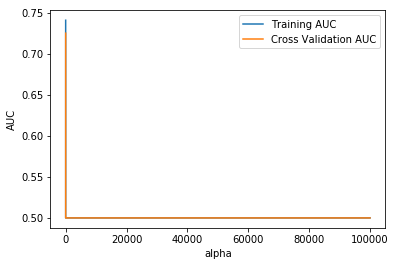

In [8]:
# Plot of AUC w.r.t. alpha on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_BOW.joblib')
TR_scores = joblib.load('TR_scores_SVM_BOW.joblib')

TR_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_alpha]
plt.plot(TR_alpha, TR_values, label = 'Training AUC')


CV_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_alpha]
plt.plot(CV_alpha, CV_values, label = 'Cross Validation AUC')

plt.xlabel('alpha')
plt.ylabel('AUC');
plt.legend()
plt.show()

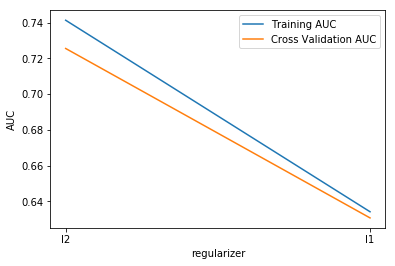

In [11]:
# Plot of AUC w.r.t. penalty on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_BOW.joblib')
TR_scores = joblib.load('TR_scores_SVM_BOW.joblib')

TR_regularizer = ['l2','l1']
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_regularizer]
plt.plot(TR_regularizer, TR_values, label = 'Training AUC')


CV_regularizer = ['l2','l1']
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_regularizer]
plt.plot(CV_regularizer,CV_values, label = 'Cross Validation AUC')

plt.xlabel('regularizer')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [13]:
# # Plot of AUC w.r.t. alpha and penalty value on training and cross validation data
# cv_scores = joblib.load('cv_scores_SVM_BOW.joblib')
# TR_scores = joblib.load('TR_scores_SVM_BOW.joblib')

# fig = plt.figure(figsize=(8,7))
# a = list(TR_scores.keys())
# TR_alpha = [i[0] for i in a]
# TR_regularizer = [i[1] for i in a]
# TR_values = list(TR_scores.values())
# ax = plt.axes(projection='3d')
# ax.scatter3D(TR_alpha, TR_regularizer, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

# a = list(cv_scores.keys())
# CV_alpha = [i[0] for i in a]
# CV_regularizer = [i[1] for i in a]
# CV_values = list(cv_scores.values())
# ax.scatter3D(CV_alpha, CV_regularizer, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

# ax.set_xlabel('alpha')
# ax.set_ylabel('regularizer')
# ax.set_zlabel('AUC');
# ax.legend()
# plt.show()

In [14]:
# Testing on test data for best alpha and regularizer value obtained from simple cross validation
model = linear_model.SGDClassifier(loss='hinge', alpha=0.001, penalty='l2', n_jobs = -1)
model.fit(x_trBOW, y_tr)
train_pred = model.predict(x_trBOW)

### Receiver Operating Characteristic (ROC) Train data 

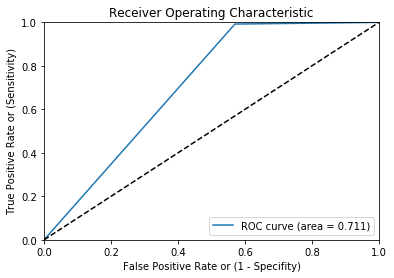

In [15]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [16]:
pred = model.predict(x_tsBOW)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.6981266195059656

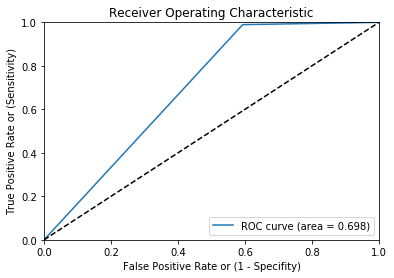

In [17]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best alpha and regularizer to be 0.001, 'l2' and AUC decreases as we increase alpha from 0.001. The test AUC for alpha = 0.001and regularizer = 'l2'  is 0.69812, stating the model did not overfit.

### Performance metrics of classification for train and test data

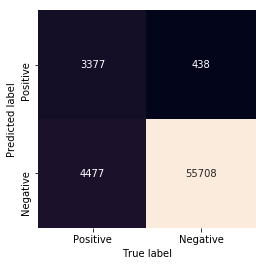

In [18]:
# Testing on train data for best alpha and regularizer obtained from simple cross validation
train_pred = model.predict(x_trBOW)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [19]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

array([[  998,  1456],
       [  183, 17363]])

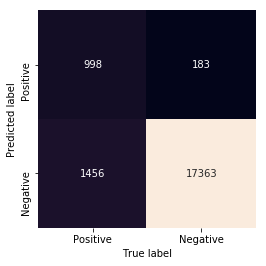

In [20]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 18361 ( = 998 + 17363) from confusion matrix and misclassified points are 1639 ( = 183+1456)

### [5.1.2] Wordcloud of top 20 important features from SET 1

In [30]:
top_features = 20
feature_names = count_vect.get_feature_names()
coef = model.coef_.ravel()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]

# positive class important words
POS_importance_feature = {}
for x in range(len(top_positive_coefficients)):
    name = feature_names[top_positive_coefficients[x]]
    importance = coef[top_positive_coefficients[x]]
    POS_importance_feature.update({name:importance})
    
# negative class important words
NEG_importance_feature = {}
for x in range(len(top_negative_coefficients)):
    name = feature_names[top_negative_coefficients[x]]
    importance = (coef[top_negative_coefficients[x]])*-1
    NEG_importance_feature.update({name:importance})

#### Wordcloud for positive class

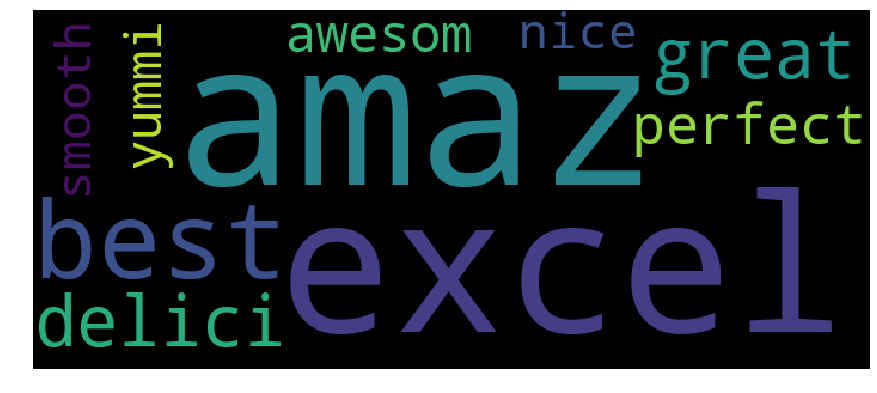

In [66]:
imp = list(POS_importance_feature)
imp.sort(reverse=True)

#from operator import itemgetter
imp_feature = dict(sorted(POS_importance_feature.items(), key=itemgetter(1), reverse=True)[:20])
#from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join([i[0] for i in imp_feature])
wordcloud = WordCloud(width = 700, height = 300).fit_words(imp_feature)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

#### Wordcloud for negative class

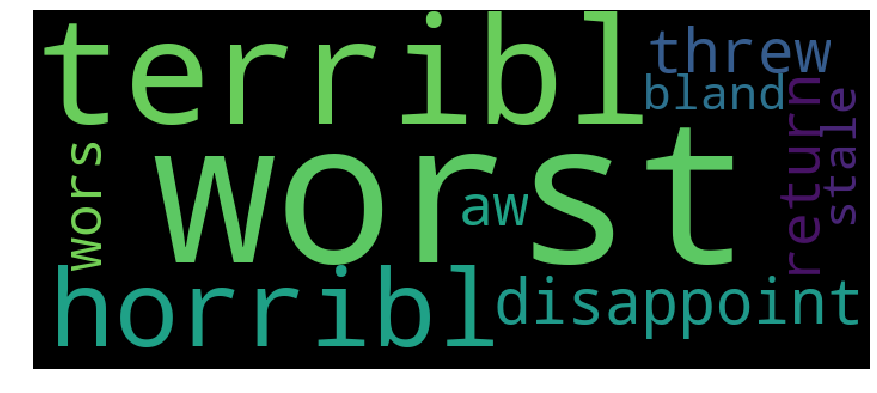

In [68]:
imp = list(NEG_importance_feature)
imp.sort(reverse=True)

#from operator import itemgetter
imp_feature = dict(sorted(NEG_importance_feature.items(), key=itemgetter(1), reverse=True)[:20])

#from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join([i[0] for i in imp_feature])
wordcloud = WordCloud(width = 700, height = 300).fit_words(imp_feature)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

### [5.1.2] Applying Linear SVM on TFIDF,<font color='red'> SET 2</font>

In [69]:
# Reading the previously created BoW100k feature matirx.
x_trTFIDF = joblib.load('x_train_TFIDF.joblib')
x_CVTFIDF = joblib.load('x_CV_TFIDF.joblib')
x_tsTFIDF = joblib.load('x_test_TFIDF.joblib')
# x_trTFIDF x_CVTFIDF x_tsTFIDF

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [70]:
cv_scores = {}
TR_scores = {}
alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
regularizer = ['l2','l1']
for i in tqdm(alpha):
    for j in regularizer:
        # instantiate learning model
        model = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty=j, n_jobs = -1)
        model.fit(x_trTFIDF, y_tr) # fitting the model on train data
        train_pred = model.predict(x_trTFIDF) # predict the response on the train data
        pred = model.predict(x_CVTFIDF) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

100%|██████████| 9/9 [00:01<00:00,  6.40it/s]


In [73]:
# Saving the scores obtained on train data and cross validation data. 
from sklearn.externals import joblib
joblib.dump(cv_scores, 'cv_scores_SVM_TFIDF.joblib')
joblib.dump(TR_scores, 'TR_scores_SVM_TFIDF.joblib')

['TR_scores_SVM_TFIDF.joblib']

In [74]:
cv_scores = joblib.load('cv_scores_SVM_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_SVM_TFIDF.joblib')

In [75]:
max(zip(cv_scores.values(), cv_scores.keys()))

(0.500254712175242, (0.001, 'l2'))

#### Observations: 0.50025 is the highest AUC with alpha = 0.001 and penalty = 'l2'. The AUC for the various combination of the alpha and penalty is varying respectively.

### Plot of AUC w.r.t. alpha and penalty value on training and cross validation data.

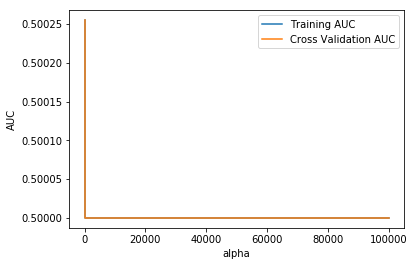

In [76]:
# Plot of AUC w.r.t. alpha on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_SVM_TFIDF.joblib')

TR_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_alpha]
plt.plot(TR_alpha, TR_values, label = 'Training AUC')


CV_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_alpha]
plt.plot(CV_alpha, CV_values, label = 'Cross Validation AUC')

plt.xlabel('alpha')
plt.ylabel('AUC');
plt.legend()
plt.show()

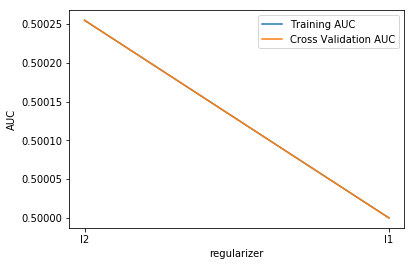

In [77]:
# Plot of AUC w.r.t. penalty on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_SVM_TFIDF.joblib')

TR_regularizer = ['l2','l1']
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_regularizer]
plt.plot(TR_regularizer, TR_values, label = 'Training AUC')


CV_regularizer = ['l2','l1']
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_regularizer]
plt.plot(CV_regularizer,CV_values, label = 'Cross Validation AUC')

plt.xlabel('regularizer')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# # Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
# cv_scores = joblib.load('cv_scores_RF_TFIDF.joblib')
# TR_scores = joblib.load('TR_scores_RF_TFIDF.joblib')

# fig = plt.figure(figsize=(8,7))
# a = list(TR_scores.keys())
# TR_n_estimators = [i[0] for i in a]
# TR_max_depth = [i[1] for i in a]
# TR_values = list(TR_scores.values())
# ax = plt.axes(projection='3d')
# ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

# a = list(cv_scores.keys())
# CV_n_estimators = [i[0] for i in a]
# CV_max_depth = [i[1] for i in a]
# CV_values = list(cv_scores.values())
# ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

# ax.set_xlabel('n_estimators')
# ax.set_ylabel('max_depth')
# ax.set_zlabel('AUC');
# ax.legend()
# plt.show()

In [78]:
# Testing on test data for best alpha and regularizer value obtained from simple cross validation
model = linear_model.SGDClassifier(loss='hinge', alpha=0.001, penalty='l2', n_jobs = -1)
model.fit(x_trTFIDF, y_tr)
train_pred = model.predict(x_trTFIDF)

### Receiver Operating Characteristic (ROC) Train data

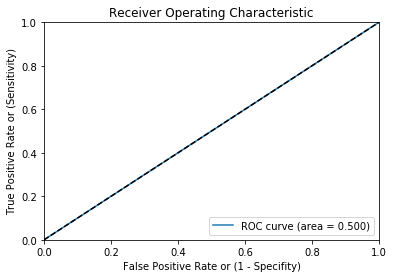

In [79]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [80]:
pred = model.predict(x_tsTFIDF)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.5002037489812551

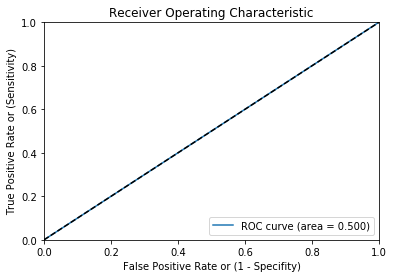

In [81]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best alpha and regularizer to be 0.001, 'l2' and AUC decreases as we increase alpha from 0.001. The test AUC for alpha = 0.001and regularizer = 'l2'  is 0.50020, stating the model did not overfit and is not giving exceedingly good results.

### Performance metrics of classification for train and test data

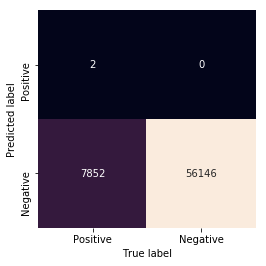

In [82]:
# Testing on train data for best alpha and regularizer obtained from simple cross validation
train_pred = model.predict(x_trTFIDF)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [83]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

array([[    1,  2453],
       [    0, 17546]])

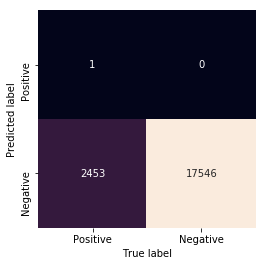

In [84]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 17547 ( = 1 + 17546) from confusion matrix and misclassified points are 2453 ( = 0 + 2453)

### [5.1.4] Wordcloud of top 20 important features from SET 2

In [86]:
top_features = 20
feature_names = tf_idf_vect.get_feature_names()
coef = model.coef_.ravel()
top_positive_coefficients = np.argsort(coef)[-top_features:]
top_negative_coefficients = np.argsort(coef)[:top_features]

# positive class important words
POS_importance_feature = {}
for x in range(len(top_positive_coefficients)):
    name = feature_names[top_positive_coefficients[x]]
    importance = coef[top_positive_coefficients[x]]
    POS_importance_feature.update({name:importance})
    
# negative class important words
NEG_importance_feature = {}
for x in range(len(top_negative_coefficients)):
    name = feature_names[top_negative_coefficients[x]]
    importance = (coef[top_negative_coefficients[x]])*-1
    NEG_importance_feature.update({name:importance})

#### Wordcloud for positive class

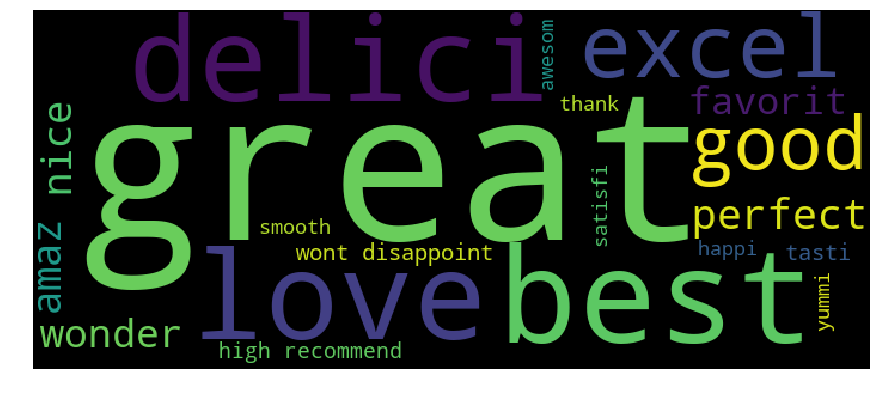

In [87]:
imp = list(POS_importance_feature)
imp.sort(reverse=True)

#from operator import itemgetter
imp_feature = dict(sorted(POS_importance_feature.items(), key=itemgetter(1), reverse=True)[:20])
#from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join([i[0] for i in imp_feature])
wordcloud = WordCloud(width = 700, height = 300).fit_words(imp_feature)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

#### Wordcloud for negative class

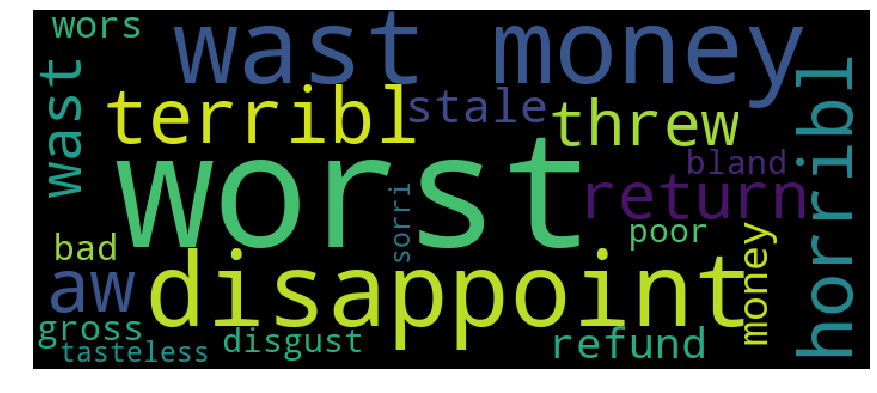

In [88]:
imp = list(NEG_importance_feature)
imp.sort(reverse=True)

#from operator import itemgetter
imp_feature = dict(sorted(NEG_importance_feature.items(), key=itemgetter(1), reverse=True)[:20])

#from wordcloud import WordCloud

#convert list to string and generate
unique_string=(" ").join([i[0] for i in imp_feature])
wordcloud = WordCloud(width = 700, height = 300).fit_words(imp_feature)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")
#plt.savefig("your_file_name"+".png", bbox_inches='tight')
plt.show()
plt.close()

### [5.1.3]  Applying Linear SVM on AVG W2V,<font color='red'> SET 3</font>

In [89]:
# Reading the previously created BoW100k feature matirx.
x_train_AVG_W2V = joblib.load('x_train_AVG_W2V.joblib')
x_CV_AVG_W2V = joblib.load('x_CV_AVG_W2V.joblib')
x_test_AVG_W2V = joblib.load('x_test_AVG_W2V.joblib')
# x_train_AVG_W2V x_CV_AVG_W2V x_test_AVG_W2V

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [90]:
cv_scores = {}
TR_scores = {}
alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
regularizer = ['l2','l1']
for i in tqdm(alpha):
    for j in regularizer:
        # instantiate learning model
        model = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty=j, n_jobs = -1)
        model.fit(x_train_AVG_W2V, y_tr) # fitting the model on train data
        train_pred = model.predict(x_train_AVG_W2V) # predict the response on the train data
        pred = model.predict(x_CV_AVG_W2V) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

100%|██████████| 9/9 [00:02<00:00,  3.77it/s]


In [93]:
# Saving the scores obtained on train data and cross validation data. 
from sklearn.externals import joblib
joblib.dump(cv_scores, 'cv_scores_SVM_AVG_W2V.joblib')
joblib.dump(TR_scores, 'TR_scores_SVM_AVG_W2V.joblib')

['TR_scores_SVM_AVG_W2V.joblib']

In [94]:
cv_scores = joblib.load('cv_scores_SVM_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_SVM_AVG_W2V.joblib')

In [95]:
max(zip(cv_scores.values(), cv_scores.keys()))  

(0.6253901930314363, (0.001, 'l2'))

#### Observations: 0.62539 is the highest AUC with alpha = 0.001 and penalty = 'l2'. The AUC for the various combination of the alpha and penalty is varying respectively.

### Plot of AUC w.r.t. alpha and penalty value on training and cross validation data.

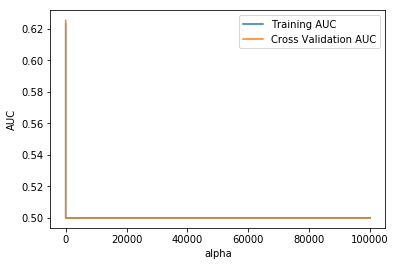

In [96]:
# Plot of AUC w.r.t. alpha on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_SVM_AVG_W2V.joblib')

TR_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_alpha]
plt.plot(TR_alpha, TR_values, label = 'Training AUC')


CV_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_alpha]
plt.plot(CV_alpha, CV_values, label = 'Cross Validation AUC')

plt.xlabel('alpha')
plt.ylabel('AUC');
plt.legend()
plt.show()

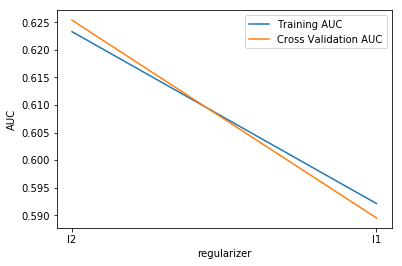

In [97]:
# Plot of AUC w.r.t. penalty on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_SVM_AVG_W2V.joblib')

TR_regularizer = ['l2','l1']
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_regularizer]
plt.plot(TR_regularizer, TR_values, label = 'Training AUC')


CV_regularizer = ['l2','l1']
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_regularizer]
plt.plot(CV_regularizer,CV_values, label = 'Cross Validation AUC')

plt.xlabel('regularizer')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# # Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
# cv_scores = joblib.load('cv_scores_RF_AVG_W2V.joblib')
# TR_scores = joblib.load('TR_scores_RF_AVG_W2V.joblib')

# fig = plt.figure(figsize=(8,7))
# a = list(TR_scores.keys())
# TR_n_estimators = [i[0] for i in a]
# TR_max_depth = [i[1] for i in a]
# TR_values = list(TR_scores.values())
# ax = plt.axes(projection='3d')
# ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

# a = list(cv_scores.keys())
# CV_n_estimators = [i[0] for i in a]
# CV_max_depth = [i[1] for i in a]
# CV_values = list(cv_scores.values())
# ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

# ax.set_xlabel('n_estimators')
# ax.set_ylabel('max_depth')
# ax.set_zlabel('AUC');
# ax.legend()
# plt.show()

In [98]:
# Testing on test data for best alpha and regularizer value obtained from simple cross validation
model = linear_model.SGDClassifier(loss='hinge', alpha=0.001, penalty='l2', n_jobs = -1)
model.fit(x_train_AVG_W2V, y_tr)
train_pred = model.predict(x_train_AVG_W2V)

### Receiver Operating Characteristic (ROC) Train data

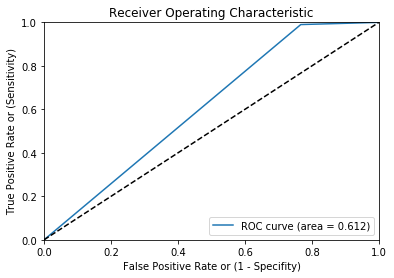

In [99]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [100]:
pred = model.predict(x_test_AVG_W2V)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.6078444542235285

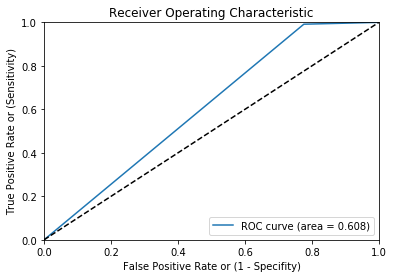

In [101]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best alpha and regularizer to be 0.001, 'l2' and AUC decreases as we increase alpha from 0.001. The test AUC for alpha = 0.001 and regularizer = 'l2'  is 0.60784, stating the model did not overfit.

### Performance metrics of classification for train and test data

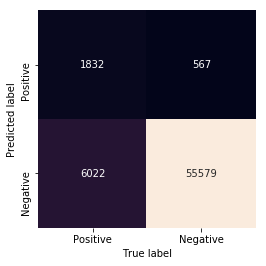

In [102]:
# Testing on train data for best best alpha and regularizer obtained from simple cross validation
train_pred = model.predict(x_train_AVG_W2V)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [103]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

array([[  550,  1904],
       [  148, 17398]])

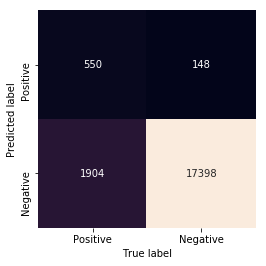

In [104]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 17948 ( = 550+17398) from confusion matrix and misclassified points are 2052 ( = 1904+148)

### [5.1.4]  Applying Linear SVM on TFIDF W2V,<font color='red'> SET 4</font>

In [105]:
# Reading the previously created BoW100k feature matirx.
x_train_AVG_TFIDF_W_W2V = joblib.load('x_train_AVG_TFIDF_weighted_W2V.joblib')
x_CV_AVG_TFIDF_W_W2V = joblib.load('x_CV_AVG_TFIDF_weighted_W2V.joblib')
x_test_AVG_TFIDF_W_W2V = joblib.load('x_test_AVG_TFIDF_weighted_W2V.joblib')
# x_train_AVG_TFIDF_W_W2V    x_CV_AVG_TFIDF_W_W2V    x_test_AVG_TFIDF_W_W2V

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [106]:
cv_scores = {}
TR_scores = {}
alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
regularizer = ['l2','l1']
for i in tqdm(alpha):
    for j in regularizer:
        # instantiate learning model
        model = linear_model.SGDClassifier(loss='hinge', alpha=i, penalty=j, n_jobs = -1)
        model.fit(x_train_AVG_TFIDF_W_W2V, y_tr) # fitting the model on train data
        train_pred = model.predict(x_train_AVG_TFIDF_W_W2V) # predict the response on the train data
        pred = model.predict(x_CV_AVG_TFIDF_W_W2V) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

100%|██████████| 9/9 [00:02<00:00,  3.71it/s]


In [112]:
# Saving the scores obtained on train data and cross validation data. 
from sklearn.externals import joblib
joblib.dump(cv_scores, 'cv_scores_SVM_AVG_TFIDF_W_W2V.joblib')
joblib.dump(TR_scores, 'TR_scores_SVM_AVG_TFIDF_W_W2V.joblib')

['TR_scores_SVM_AVG_TFIDF_W_W2V.joblib']

In [113]:
cv_scores = joblib.load('cv_scores_SVM_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_SVM_AVG_TFIDF_W_W2V.joblib')

In [114]:
max(zip(cv_scores.values(), cv_scores.keys()))  

(0.5144224758444416, (0.001, 'l2'))

#### Observations: 0.51442 is the highest AUC with alpha = 0.001 and penalty = 'l2'. The AUC for the various combination of the alpha and penalty is varying respectively.

### Plot of AUC w.r.t. alpha and penalty value on training and cross validation data.

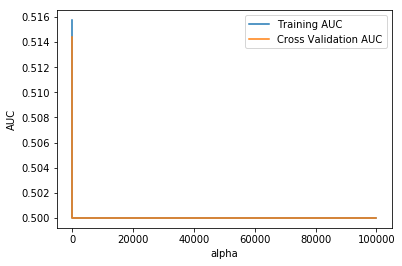

In [115]:
# Plot of AUC w.r.t. alpha on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_SVM_AVG_TFIDF_W_W2V.joblib')

TR_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_alpha]
plt.plot(TR_alpha, TR_values, label = 'Training AUC')


CV_alpha = [10e-4,10e-3,10e-2,10e-1,10e0,10e1,10e2,10e3,10e4]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_alpha]
plt.plot(CV_alpha, CV_values, label = 'Cross Validation AUC')

plt.xlabel('alpha')
plt.ylabel('AUC');
plt.legend()
plt.show()

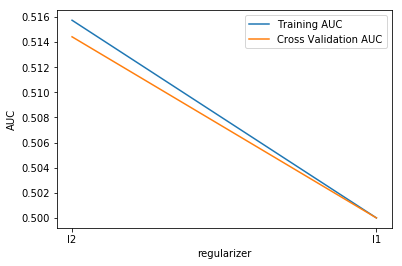

In [116]:
# Plot of AUC w.r.t. penalty on training and cross validation data
cv_scores = joblib.load('cv_scores_SVM_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_SVM_AVG_TFIDF_W_W2V.joblib')

TR_regularizer = ['l2','l1']
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_regularizer]
plt.plot(TR_regularizer, TR_values, label = 'Training AUC')


CV_regularizer = ['l2','l1']
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_regularizer]
plt.plot(CV_regularizer,CV_values, label = 'Cross Validation AUC')

plt.xlabel('regularizer')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# # Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
# cv_scores = joblib.load('cv_scores_RF_AVG_TFIDF_W_W2V.joblib')
# TR_scores = joblib.load('TR_scores_RF_AVG_TFIDF_W_W2V.joblib')

# fig = plt.figure(figsize=(8,7))
# a = list(TR_scores.keys())
# TR_n_estimators = [i[0] for i in a]
# TR_max_depth = [i[1] for i in a]
# TR_values = list(TR_scores.values())
# ax = plt.axes(projection='3d')
# ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

# a = list(cv_scores.keys())
# CV_n_estimators = [i[0] for i in a]
# CV_max_depth = [i[1] for i in a]
# CV_values = list(cv_scores.values())
# ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

# ax.set_xlabel('n_estimators')
# ax.set_ylabel('max_depth')
# ax.set_zlabel('AUC');
# ax.legend()
# plt.show()

In [117]:
# Testing on test data for best alpha and regularizer value obtained from simple cross validation
model = linear_model.SGDClassifier(loss='hinge', alpha=0.001, penalty='l2', n_jobs = -1)
model.fit(x_train_AVG_TFIDF_W_W2V, y_tr)
train_pred = model.predict(x_train_AVG_TFIDF_W_W2V)

### Receiver Operating Characteristic (ROC) Train data

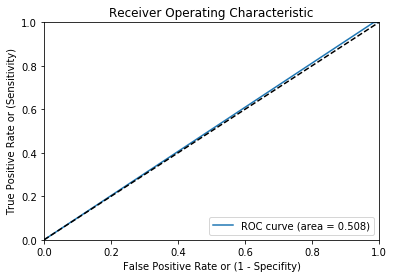

In [118]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data¶

In [119]:
pred = model.predict(x_test_AVG_TFIDF_W_W2V)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

0.5053060201472046

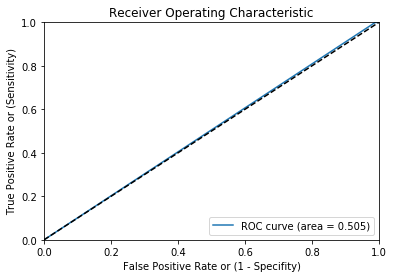

In [120]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best alpha and regularizer to be 0.001, 'l2' and AUC decreases as we increase alpha from 0.001. The test AUC for alpha = 0.001and regularizer = 'l2'  is 0.50530, stating the model did not overfit.

### Performance metrics of classification for train and test data

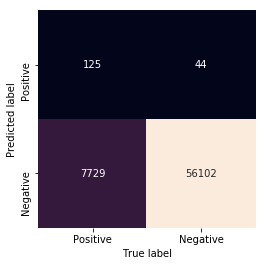

In [121]:
# Testing on train data for best best alpha and regularizer obtained from simple cross validation
train_pred = model.predict(x_train_AVG_TFIDF_W_W2V)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [122]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

array([[   28,  2426],
       [   14, 17532]])

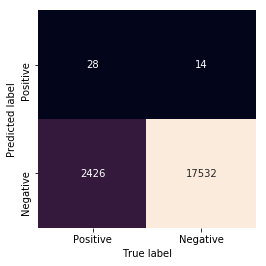

In [123]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 17560 ( = 28+17532) from confusion matrix and misclassified points are 2440 ( = 2426+14)

## [5.2] RBF SVM

### [5.2.1] Applying RBF SVM on BOW,<font color='red'> SET 1</font>

In [174]:
# Reading the previously created BoW40k feature matirx.
x_trBOW = joblib.load('x_train_BOW.joblib')
x_CVBOW = joblib.load('x_CV_BOW.joblib')
x_tsBOW = joblib.load('x_test_BOW.joblib')
# x_trBOW x_CVBOW x_tsBOW

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# Label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
cv_scores = {}
TR_scores = {}
for i in [10, 50, 100, 200, 500]:
    for j in [1, 5, 10, 100, 500]:
        # instantiate learning model
        model = XGBClassifier(n_estimators= i, max_depth=j, random_state=101, n_jobs = -1)
        model.fit(x_trBOW, y_tr) # fitting the model on train data
        train_pred = model.predict(x_trBOW) # predict the response on the train data
        pred = model.predict(x_CVBOW) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

In [ ]:
# Saving the scores obtained on train data and cross validation data. 
joblib.dump(cv_scores, 'cv_scores_XGB_BOW.joblib')
joblib.dump(TR_scores, 'TR_scores_XGB_BOW.joblib')

In [ ]:
cv_scores = joblib.load('cv_scores_XGB_BOW.joblib')
TR_scores = joblib.load('TR_scores_XGB_BOW.joblib')

In [ ]:
max(zip(cv_scores.values(), cv_scores.keys()))

#### Observations: 0.74658 is the highest AUC with n_estimators = 500 and max_depth = 500. The AUC for the various combination(24) of the n_estimators and max_depth is varying respectively.

### Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data.

In [ ]:
# Plot of AUC w.r.t. n_estimators on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_BOW.joblib')
TR_scores = joblib.load('TR_scores_XGB_BOW.joblib')

TR_n_estimators = [10, 50, 100, 200, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_n_estimators]
plt.plot(TR_n_estimators, TR_values, label = 'Training AUC')


CV_n_estimators = [10, 50, 100, 200, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_n_estimators]
plt.plot(CV_n_estimators, CV_values, label = 'Cross Validation AUC')

plt.xlabel('n_estimators')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. max_depth on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_BOW.joblib')
TR_scores = joblib.load('TR_scores_XGB_BOW.joblib')

TR_max_depth = [1, 5, 10, 100, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_max_depth]
plt.plot(TR_max_depth, TR_values, label = 'Training AUC')


CV_max_depth = [1, 5, 10, 100, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_max_depth]
plt.plot(CV_max_depth,CV_values, label = 'Cross Validation AUC')

plt.xlabel('max_depth')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_BOW.joblib')
TR_scores = joblib.load('TR_scores_XGB_BOW.joblib')

fig = plt.figure(figsize=(8,7))
a = list(TR_scores.keys())
TR_n_estimators = [i[0] for i in a]
TR_max_depth = [i[1] for i in a]
TR_values = list(TR_scores.values())
ax = plt.axes(projection='3d')
ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

a = list(cv_scores.keys())
CV_n_estimators = [i[0] for i in a]
CV_max_depth = [i[1] for i in a]
CV_values = list(cv_scores.values())
ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('AUC');
ax.legend()
plt.show()

In [ ]:
# Testing on test data for best n_estimators and max_depth value value obtained from simple cross validation
model = XGBClassifier(random_state=101,n_estimators= 500, max_depth=500, n_jobs=-1)
model.fit(x_trBOW, y_tr)
train_pred = model.predict(x_trBOW)

### Receiver Operating Characteristic (ROC) Train data

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [ ]:
pred = model.predict(x_tsBOW)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best n_estimators and max_depth to be 500, 500 and AUC increase as we increase n_estimators from 10. The test AUC for n_estimators = 500 and max_depth = 500 is 0.75610, stating the model did not overfit.

### Performance metrics of classification for train and test data

In [ ]:
# Testing on train data for best n_estimators and max_depth obtained from simple cross validation
train_pred = model.predict(x_trBOW)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

In [ ]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 18563 ( = 1296 + 17267) from confusion matrix and misclassified points are 1437 ( = 279 + 1158)

### [5.2.2] Applying XGBOOST on TFIDF, SET 2

In [ ]:
# Reading the previously created BoW100k feature matirx.
x_trTFIDF = joblib.load('x_train_TFIDF.joblib')
x_CVTFIDF = joblib.load('x_CV_TFIDF.joblib')
x_tsTFIDF = joblib.load('x_test_TFIDF.joblib')
# x_trTFIDF x_CVTFIDF x_tsTFIDF

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
cv_scores = {}
TR_scores = {}
for i in [10, 50, 100, 200, 500]:
    for j in [1, 5, 10, 100, 500]:
        # instantiate learning model
        model = XGBClassifier(n_estimators= i, max_depth=j, random_state=101, n_jobs = -1)
        model.fit(x_trTFIDF, y_tr) # fitting the model on train data
        train_pred = model.predict(x_trTFIDF) # predict the response on the train data
        pred = model.predict(x_CVTFIDF) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

In [ ]:
# Saving the scores obtained on train data and cross validation data. 
from sklearn.externals import joblib
joblib.dump(cv_scores, 'cv_scores_XGB_TFIDF.joblib')
joblib.dump(TR_scores, 'TR_scores_XGB_TFIDF.joblib')

In [ ]:
cv_scores = joblib.load('cv_scores_XGB_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_XGB_TFIDF.joblib')

In [ ]:
max(zip(cv_scores.values(), cv_scores.keys()))

#### Observations: 0.73606 is the highest AUC with n_estimators = 500 and max_depth = 500. The AUC for the various combination(24) of the n_estimators and max_depth is varying respectively.

### Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data.¶

In [ ]:
# Plot of AUC w.r.t. n_estimators on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_XGB_TFIDF.joblib')

TR_n_estimators = [10, 50, 100, 200, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_n_estimators]
plt.plot(TR_n_estimators, TR_values, label = 'Training AUC')


CV_n_estimators = [10, 50, 100, 200, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_n_estimators]
plt.plot(CV_n_estimators, CV_values, label = 'Cross Validation AUC')

plt.xlabel('n_estimators')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. max_depth on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_XGB_TFIDF.joblib')

TR_max_depth = [1, 5, 10, 100, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_max_depth]
plt.plot(TR_max_depth, TR_values, label = 'Training AUC')


CV_max_depth = [1, 5, 10, 100, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_max_depth]
plt.plot(CV_max_depth,CV_values, label = 'Cross Validation AUC')

plt.xlabel('max_depth')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_TFIDF.joblib')
TR_scores = joblib.load('TR_scores_XGB_TFIDF.joblib')

fig = plt.figure(figsize=(8,7))
a = list(TR_scores.keys())
TR_n_estimators = [i[0] for i in a]
TR_max_depth = [i[1] for i in a]
TR_values = list(TR_scores.values())
ax = plt.axes(projection='3d')
ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

a = list(cv_scores.keys())
CV_n_estimators = [i[0] for i in a]
CV_max_depth = [i[1] for i in a]
CV_values = list(cv_scores.values())
ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('AUC');
ax.legend()
plt.show()

In [ ]:
# Testing on test data for best n_estimators and max_depth value obtained from simple cross validation
model = XGBClassifier(random_state=101,n_estimators= 500, max_depth=500, n_jobs=-1)
model.fit(x_trTFIDF, y_tr)
train_pred = model.predict(x_trTFIDF)

### Receiver Operating Characteristic (ROC) Train data

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [ ]:
pred = model.predict(x_tsTFIDF)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best n_estimators and max_depth to be 500, 500 and AUC increase as we increase n_estimators from 10. The test AUC for n_estimators = 500 and max_depth = 500 is 0.74434, stating the model did not overfit.

### Performance metrics of classification for train and test data

In [ ]:
# Testing on train data for best n_estimators and max_depth obtained from simple cross validation
train_pred = model.predict(x_trTFIDF)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

In [ ]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 18513 ( = 1237 + 17276) from confusion matrix and misclassified points are 1487 ( = 270 + 1217)

### [5.2.3] Applying XGBOOST on AVG W2V, SET 3

In [ ]:
# Reading the previously created BoW100k feature matirx.
x_train_AVG_W2V = joblib.load('x_train_AVG_W2V.joblib')
x_CV_AVG_W2V = joblib.load('x_CV_AVG_W2V.joblib')
x_test_AVG_W2V = joblib.load('x_test_AVG_W2V.joblib')
# x_train_AVG_W2V x_CV_AVG_W2V x_test_AVG_W2V

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
cv_scores = {}
TR_scores = {}
for i in [10, 50, 100, 200, 500]:
    for j in [1, 5, 10, 100, 500]:
        # instantiate learning model
        model = XGBClassifier(n_estimators= i, max_depth=j, random_state=101, n_jobs = -1)
        model.fit(x_train_AVG_W2V, y_tr) # fitting the model on train data
        train_pred = model.predict(x_train_AVG_W2V) # predict the response on the train data
        pred = model.predict(x_CV_AVG_W2V) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

In [ ]:
# Saving the scores obtained on train data and cross validation data. 
from sklearn.externals import joblib
joblib.dump(cv_scores, 'cv_scores_XGB_AVG_W2V.joblib')
joblib.dump(TR_scores, 'TR_scores_XGB_AVG_W2V.joblib')

In [ ]:
cv_scores = joblib.load('cv_scores_XGB_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_W2V.joblib')

In [ ]:
max(zip(cv_scores.values(), cv_scores.keys()))

#### Observations: 0.73606 is the highest AUC with n_estimators = 500 and max_depth = 500. The AUC for the various combination(24) of the n_estimators and max_depth is varying respectively.

### Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data.¶

In [ ]:
# Plot of AUC w.r.t. n_estimators on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_W2V.joblib')

TR_n_estimators = [10, 50, 100, 200, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_n_estimators]
plt.plot(TR_n_estimators, TR_values, label = 'Training AUC')


CV_n_estimators = [10, 50, 100, 200, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_n_estimators]
plt.plot(CV_n_estimators, CV_values, label = 'Cross Validation AUC')

plt.xlabel('n_estimators')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. max_depth on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_W2V.joblib')

TR_max_depth = [1, 5, 10, 100, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_max_depth]
plt.plot(TR_max_depth, TR_values, label = 'Training AUC')


CV_max_depth = [1, 5, 10, 100, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_max_depth]
plt.plot(CV_max_depth,CV_values, label = 'Cross Validation AUC')

plt.xlabel('max_depth')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_AVG_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_W2V.joblib')

fig = plt.figure(figsize=(8,7))
a = list(TR_scores.keys())
TR_n_estimators = [i[0] for i in a]
TR_max_depth = [i[1] for i in a]
TR_values = list(TR_scores.values())
ax = plt.axes(projection='3d')
ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

a = list(cv_scores.keys())
CV_n_estimators = [i[0] for i in a]
CV_max_depth = [i[1] for i in a]
CV_values = list(cv_scores.values())
ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('AUC');
ax.legend()
plt.show()

In [ ]:
# Testing on test data for best n_estimators and max_depth value obtained from simple cross validation
model = XGBClassifier(random_state=101,n_estimators= 500, max_depth=500, n_jobs=-1)
model.fit(x_train_AVG_W2V, y_tr)
train_pred = model.predict(x_train_AVG_W2V)

### Receiver Operating Characteristic (ROC) Train data

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [ ]:
pred = model.predict(x_test_AVG_W2V)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best n_estimators and max_depth to be 500, 500 and AUC increase as we increase n_estimators from 10. The test AUC for n_estimators = 500 and max_depth = 500 is 0.68840, stating the model did not overfit.

### Performance metrics of classification for train and test data

In [ ]:
# Testing on train data for best n_estimators and max_depth obtained from simple cross validation
train_pred = model.predict(x_train_AVG_W2V)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

In [ ]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 18229 ( = 964 + 17265) from confusion matrix and misclassified points are 1771 ( = 281 + 1490)

### [5.2.4] Applying XGBOOST on TFIDF W2V, SET 4

In [ ]:
# Reading the previously created BoW100k feature matirx.
x_train_AVG_TFIDF_W_W2V = joblib.load('x_train_AVG_TFIDF_weighted_W2V.joblib')
x_CV_AVG_TFIDF_W_W2V = joblib.load('x_CV_AVG_TFIDF_weighted_W2V.joblib')
x_test_AVG_TFIDF_W_W2V = joblib.load('x_test_AVG_TFIDF_weighted_W2V.joblib')
# x_train_AVG_TFIDF_W_W2V    x_CV_AVG_TFIDF_W_W2V    x_test_AVG_TFIDF_W_W2V

# Reading the previously created dependent matrix
y_tr = joblib.load('y_tr.joblib')
y_CV = joblib.load('y_cv.joblib')
y_test = joblib.load('y_test.joblib')
# y_tr y_CV y_test

# label encoding
y_tr = np.array(pd.get_dummies(y_tr,drop_first=True))
y_CV = np.array(pd.get_dummies(y_CV,drop_first=True))
y_test = np.array(pd.get_dummies(y_test,drop_first=True))

# Reshaping
y_tr = y_tr.reshape(y_tr.shape[0])
y_CV = y_CV.reshape(y_CV.shape[0])
y_test = y_test.reshape(y_test.shape[0])

In [ ]:
cv_scores = {}
TR_scores = {}
for i in [10, 50, 100, 200, 500]:
    for j in [1, 5, 10, 100, 500]:
        # instantiate learning model
        model = XGBClassifier(n_estimators= i, max_depth=j, random_state=101, n_jobs = -1)
        model.fit(x_train_AVG_TFIDF_W_W2V, y_tr) # fitting the model on train data
        train_pred = model.predict(x_train_AVG_TFIDF_W_W2V) # predict the response on the train data
        pred = model.predict(x_CV_AVG_TFIDF_W_W2V) # predict the response on the cross-validation data
        
        # evaluate train AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
        train_AUC = metrics.auc(fpr, tpr)
        # evaluate CV AUC
        fpr, tpr, thresholds = metrics.roc_curve(y_CV, pred)
        CV_AUC = metrics.auc(fpr, tpr)

        #print('\nCV AUC for max_depth =',i,'and min_samples_split = ',j,'is',CV_AUC)
        cv_scores.update({(i,j):CV_AUC})
        TR_scores.update({(i,j):train_AUC})

In [ ]:
# Saving the scores obtained on train data and cross validation data. 
joblib.dump(cv_scores, 'cv_scores_XGB_AVG_TFIDF_W_W2V.joblib')
joblib.dump(TR_scores, 'TR_scores_XGB_AVG_TFIDF_W_W2V.joblib')

In [ ]:
cv_scores = joblib.load('cv_scores_XGB_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_TFIDF_W_W2V.joblib')

In [ ]:
max(zip(cv_scores.values(), cv_scores.keys()))  

#### Observations: 0.66645 is the highest AUC with n_estimators = 500 and max_depth = 5. The AUC for the various combination(24) of the n_estimators and max_depth is varying respectively.

### Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data.

In [ ]:
# Plot of AUC w.r.t. n_estimators on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_TFIDF_W_W2V.joblib')

TR_n_estimators = [10, 50, 100, 200, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[0]==k]).max() for k in TR_n_estimators]
plt.plot(TR_n_estimators, TR_values, label = 'Training AUC')


CV_n_estimators = [10, 50, 100, 200, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[0]==k]).max() for k in CV_n_estimators]
plt.plot(CV_n_estimators, CV_values, label = 'Cross Validation AUC')

plt.xlabel('n_estimators')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. max_depth on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_TFIDF_W_W2V.joblib')

TR_max_depth = [1, 5, 10, 100, 500]
TR_values = [np.array([TR_scores[i] for i in TR_scores.keys() if i[1]==k]).max() for k in TR_max_depth]
plt.plot(TR_max_depth, TR_values, label = 'Training AUC')


CV_max_depth = [1, 5, 10, 100, 500]
CV_values = [np.array([cv_scores[i] for i in cv_scores.keys() if i[1]==k]).max() for k in CV_max_depth]
plt.plot(CV_max_depth,CV_values, label = 'Cross Validation AUC')

plt.xlabel('max_depth')
plt.ylabel('AUC');
plt.legend()
plt.show()

In [ ]:
# Plot of AUC w.r.t. n_estimators and max_depth value on training and cross validation data
cv_scores = joblib.load('cv_scores_XGB_AVG_TFIDF_W_W2V.joblib')
TR_scores = joblib.load('TR_scores_XGB_AVG_TFIDF_W_W2V.joblib')

fig = plt.figure(figsize=(8,7))
a = list(TR_scores.keys())
TR_n_estimators = [i[0] for i in a]
TR_max_depth = [i[1] for i in a]
TR_values = list(TR_scores.values())
ax = plt.axes(projection='3d')
ax.scatter3D(TR_n_estimators, TR_max_depth, TR_values, c=TR_values, cmap='Blues', label = 'Training AUC');

a = list(cv_scores.keys())
CV_n_estimators = [i[0] for i in a]
CV_max_depth = [i[1] for i in a]
CV_values = list(cv_scores.values())
ax.scatter3D(CV_n_estimators, CV_max_depth, CV_values, c=CV_values, cmap='Reds', label = 'Cross Validation AUC');

ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('AUC');
ax.legend()
plt.show()

In [ ]:
# Testing on test data for best n_estimators and max_depth value obtained from simple cross validation
model = XGBClassifier(random_state=101,n_estimators= 500, max_depth=5, n_jobs=-1)
model.fit(x_train_AVG_TFIDF_W_W2V, y_tr)
train_pred = model.predict(x_train_AVG_TFIDF_W_W2V)

### Receiver Operating Characteristic (ROC) Train data

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_tr, train_pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

### Receiver Operating Characteristic (ROC) Test data

In [ ]:
pred = model.predict(x_test_AVG_TFIDF_W_W2V)
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
metrics.auc(fpr, tpr)

In [ ]:
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

#### Observation: From simple cross validation we found the best n_estimators and max_depth to be 500, 5 and AUC increase as we increase n_estimators from 10. The test AUC for n_estimators = 500 and max_depth = 5 is 0.65861, stating the model did not overfit.

### Performance metrics of classification for train and test data

In [ ]:
# Testing on train data for best n_estimators and max_depth obtained from simple cross validation
train_pred = model.predict(x_train_AVG_TFIDF_W_W2V)
# confusion matrix for train data
mat = confusion_matrix(y_tr, train_pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

In [ ]:
# confusion matrix for test data
confusion_matrix(y_test, pred)

In [ ]:
mat = confusion_matrix(y_test, pred)
target_names = ['Positive', 'Negative']
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('True label')
plt.ylabel('Predicted label');

#### Observations: Correctly classified points in the test data are 18020 ( = 828 + 17192) from confusion matrix and misclassified points are 1980 ( = 354 + 1626)

# Conclusions

In [ ]:
from prettytable import PrettyTable  
x = PrettyTable()

x.field_names = ["Algorithm", "Featurization","n_estimators","max_depth", "CV_AUC", "Test_AUC"]

x.add_row(["Random Forest", "BOW",10, 500,0.66315, 0.66752])
x.add_row(["Random Forest", "TF-IDF", 10, 500, 0.65443, 0.65844])
x.add_row(["Random Forest","AVG W2V",10, 500, 0.64244, 0.64598])
x.add_row(["Random Forest", "TFIDF W W2V", 10, 500, 0.61057, 0.60637])
x.add_row(["---------","-----------", "-----------","-----------","-----------","-----------"])
x.add_row(["---------","-----------", "-----------","-----------","-----------","-----------"])
x.add_row(["XGBOOST", "BOW",500, 500,0.74658, 0.75611])
x.add_row(["XGBOOST", "TF-IDF", 500, 500, 0.73606, 0.74434])
x.add_row(["XGBOOST","AVG W2V",500, 500, 0.73606, 0.68841])
x.add_row(["XGBOOST", "TFIDF W W2V", 500, 5, 0.66645,0.65861])
print(x)

#### Observations: Random Forest
1. Highest AUC is achieved by Bag Of Words featurization method as 0.66315 on CV data and 0.66752 on test data for Random Forest.
2. In Random Forest algorithms, Bag Of Words featurization method has out performed all other methods with n_estimators = 10 and max_depth = 500.
3. All featurization method have the best n_estimators = 10 and max_depth = 500.
4. All the featurization method have AUC for cross validation and test data above average value
5. There is a drastic increases in AUC for both cross validation and test data going from TFIDF Weighted W2V to Bag Of Words featurization method.

#### Observations:  XGBOOST
1. Highest AUC is achieved by Bag Of Words featurization method as 0.74658 on CV data and 0.75611 on test data for XGBOOST.
2. In XGBOOST algorithms, Bag Of Words featurization method has out performed all other methods with n_estimators = 500 and max_depth = 500.
3. All featurization method have the best n_estimators = 500 and max_depth = 500 except for TFIDF W W2V which is 5.
4. All the featurization method have AUC for cross validation and test data above average value
5. There is a drastic increases in AUC for both cross validation and test data going from TFIDF Weighted W2V to Bag Of Words featurization method.

#### Conclusions:
1. Bag Of Words featurization method outperformed all other featurization methods for both Random Forest and XGBOOST algorithms. 
2. There is a drastic increases in AUC from TFIDF Weighted W2V to Bag Of Words featurization method.
3. In Random Forest, the important feature obtained from TFIDF and Bag Of Words are different from each other.
4. XGBOOST has achieved the highest AUC till now among all other machine learning algorithms, reaching the highest of 0.75611 on test data.